## Setup and example demonstration from sample code given

In [35]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [36]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import Video
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

np.bool8=np.bool_

In [37]:
env = gym.make("CartPole-v1")

In [38]:
print(env.action_space)

Discrete(2)


In [39]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [40]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.04788142 -0.03953488  0.02949958  0.04523197]


In [41]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.04709072 -0.23506714  0.03040422  0.3470744 ]
Reward for this step: 1.0
Is this round done? False


In [42]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


In [43]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

In [44]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.00170814  0.00430824 -0.03357204  0.01820106]
Chosen action: 1


## Notebook Setup:

To get our results, all you need to do is to run all the cells sequentially.

We are using Q-learning that involves the generation of a Q-table to be used to solve the cartpole problem.

in the generation of the Q-table, we have programmed the code to retrain and regenerate the Q-table until the average reward obtained from the training is above 195, the task requirement. Since we are directly training the agent in the code itself instead of using a pre-trained agent, the training time of the agent might take several minutes.

## Work Distribution Breakdown:

Goh Qing Wen (U2322556F):

Iteration and developement of RL Agent, completing all tasks (50%)

  
Firdaus Khan Feroz Khan (U2321374A):

Iteration and developement of RL Agent, completing all tasks (50%)


## Task 1: Development of RL Agent

For this task we will be using Q learning as our RL Agent




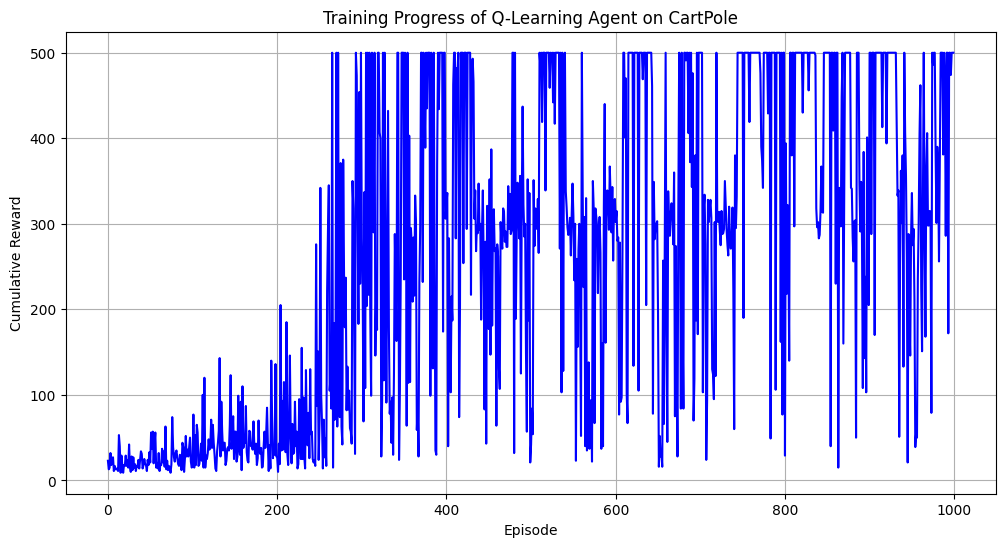

Training complete!
Final episode reward: 500.0
Average reward over 1000 episodes: 260.46


In [45]:
# Importing necessary libraries and functions:
import numpy as np
import random
import gym
import matplotlib.pyplot as plt

# Initialize the environment
env = gym.make('CartPole-v1')


# Before starting the training, we first define the Q-table itself.
# Since the CartPole environment is continous instead of discrete, we need to discretize the state space into several bins
# For our implementation, out of the 4 different variables: Cart Position, Cart Velocity, Pole Angle and Pole Velocity,
# we will be focussing on only Cart Position and Cart Velocity for simplicity.



# angle_bins discretizes pole angle between -0.2095 and 0.2095 radians into 15 different bins
angle_bins = np.linspace(-0.2095, 0.2095, 15)

# velocity_bins → Discretizes angular velocity between -4 and 4 into 15 different bins.
velocity_bins = np.linspace(-4, 4, 15)

# Next we initialise the Q-table
# Here we create a Q-table shape of: (2,15,15)
# "2" represents the number of possible actions in the CartPole problem, with 0 representing a move to the left and 1 representing a move to the right.
# Each "15" represents the bins for both the Pole Angle and Pole Angular Velocity
# Initially all Q-values in the Q-table are set to 0 using "np.zeros"
q_values = np.zeros((2, len(angle_bins), len(velocity_bins)))

# Next, "get_state()" is a function that converts a continuous state of the CartPole environemnt into a discrete state for our Q-table
# The function first extracts pole angle and angular velocity from the environment state using "observation[2]" and "observation[3]"
# "np.digitize()" maps the continuous values into discrete bins.
# The function also ensures the indices are within valid range using min() and max().
def get_state(observation):
    pole_angle, pole_angular_velocity = observation[2], observation[3]

    angle_state = np.digitize(pole_angle, angle_bins) - 1
    angle_state = min(max(angle_state, 0), len(angle_bins) - 1)

    vel_state = np.digitize(pole_angular_velocity, velocity_bins) - 1
    vel_state = min(max(vel_state, 0), len(velocity_bins) - 1)

    return (angle_state, vel_state)



# Next, we define an Epsilon-greedy function to select the next action (left or right)
# Applying a different concept than what was learnt from the lectures, the function will return a random action if a generated number (between 0 and 1) is
# lower than our epsilon value. Otherwise, it will return an action with the highest value based on the existing values in the Q-table at that moment.
def next_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 1)
    return np.argmax(q_values[:, state[0], state[1]])

# Defining the necessary parameters to apply q learning
epsilon = 0.9
discount_factor = 0.99
learning_rate = 0.1


# Following this, we create a training loop that runs 1000 episodes per training cycle.
# We continue training the agent until the agent achives an average reward of at least 250
episodes = 1000


average_reward = 0
while average_reward < 250:
  q_values = np.zeros((2, len(angle_bins), len(velocity_bins)))
  epsilon = 0.9
  reward_history = []

  # For each episode execution, the code runs until done is True, where either the Pole falls or episode reaches max steps.
  # Similar to what was covered in the lectures and example code,
  # the code first gets the current state, then chooses an action using epsilon-greedy function, executes the selected action in the environment and repeats
  for episode in range(episodes):
      observation = env.reset()
      cumulative_reward = 0
      done = False

      while not done:

          state = get_state(observation)
          action = next_action(state, epsilon)

          observation, reward, done, info = env.step(action)


          next_state = get_state(observation)

          # Here is where the values in the Q-table are updated, using the Q-learning formula taught in lectures
          old_q = q_values[action, state[0], state[1]]
          td_error = reward + (discount_factor * np.max(q_values[:, next_state[0], next_state[1]])) - old_q
          q_values[action, state[0], state[1]] += learning_rate * td_error


          cumulative_reward += reward

      # Following which, we track the episode reward and store it in reward_history for plotting
      reward_history.append(cumulative_reward)

      # For our implementation, we use the concept of epsilon decay instead of using a fixed epsilon value
      # Intially, with all the q values being 0, we need the epsilon value to be high to make it more likely that the epsilon-greedy function to use the random action part
      # This encourages meaningful exploration, instead of using the zeroed Q-table values
      # After each round we decrease the epsilon value by a small amount.
      # This ensures that as the episode number increases, and more values in the Q-table are updated, we decrease the chance that the random action part is chosen
      # so that the agent is more likely to use the Q-table values to decide the action.
      # With more updated Q-table values, and with a higher likelihood of the agent using the Q-table values to choose the
      # next action, the agent will make decisions that leads to a higher reward
      epsilon = max(0.1, epsilon * 0.995)

  average_reward = np.mean(reward_history)

# Lastly,  we plot training performance and display the final training results (for reference)

# Plotting the training graph
plt.figure(figsize=(12,6))
plt.plot(reward_history, color='blue')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress of Q-Learning Agent on CartPole')
plt.grid(True)
plt.show()

# Display final results
print('Training complete!')
print(f"Final episode reward: {cumulative_reward}")
print(f"Average reward over {episodes} episodes: {average_reward:.2f}")

Demonstrating correctness of agent:

In [46]:
observation = env.reset()
action = np.argmax(q_values[:, state[0], state[1]])
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.00801086  0.0073708  -0.00458255  0.03218403]
Chosen action: 0


## Task 2: : Demonstrate the effectiveness of the RL agent

In this task, the trained Q-learning agent is tested over 100 episodes to evaluate its performance.

Cumulative rewards for each episode are recorded for plotting.

Episode 1: Cumulative Reward = 500.0
Episode 2: Cumulative Reward = 500.0
Episode 3: Cumulative Reward = 500.0
Episode 4: Cumulative Reward = 500.0
Episode 5: Cumulative Reward = 500.0
Episode 6: Cumulative Reward = 500.0
Episode 7: Cumulative Reward = 500.0
Episode 8: Cumulative Reward = 500.0
Episode 9: Cumulative Reward = 500.0
Episode 10: Cumulative Reward = 500.0
Episode 11: Cumulative Reward = 500.0
Episode 12: Cumulative Reward = 500.0
Episode 13: Cumulative Reward = 500.0
Episode 14: Cumulative Reward = 500.0
Episode 15: Cumulative Reward = 500.0
Episode 16: Cumulative Reward = 500.0
Episode 17: Cumulative Reward = 500.0
Episode 18: Cumulative Reward = 500.0
Episode 19: Cumulative Reward = 500.0
Episode 20: Cumulative Reward = 500.0
Episode 21: Cumulative Reward = 500.0
Episode 22: Cumulative Reward = 500.0
Episode 23: Cumulative Reward = 500.0
Episode 24: Cumulative Reward = 500.0
Episode 25: Cumulative Reward = 500.0
Episode 26: Cumulative Reward = 500.0
Episode 27: Cumulativ

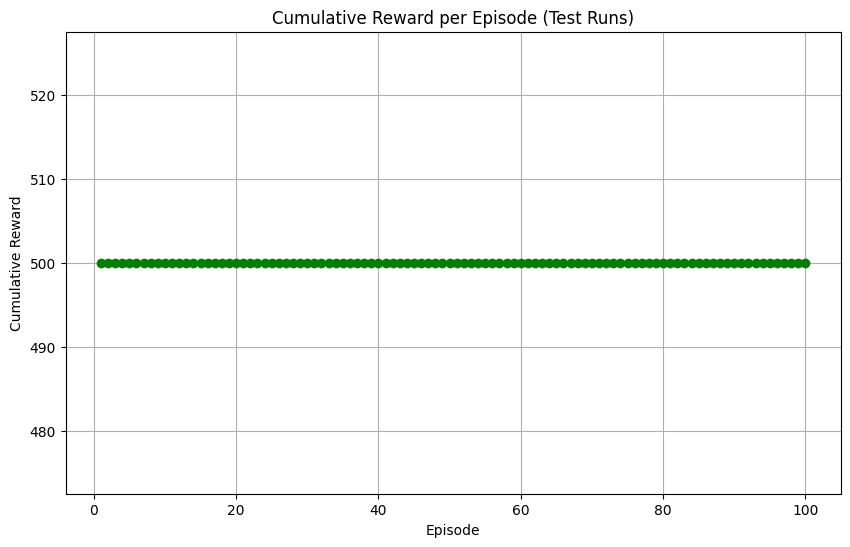

Average reward over 100 episodes is: 500.00


In [47]:
import numpy as np
import matplotlib.pyplot as plt

num_test_episodes = 100
cumulative_rewards = []

for episode in range(num_test_episodes):
    observation = env.reset()
    cumulative_reward = 0
    done = False

    while not done:
        state = get_state(observation)
        action = np.argmax(q_values[:, state[0], state[1]])
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward

    cumulative_rewards.append(cumulative_reward)
    print(f'Episode {episode + 1}: Cumulative Reward = {cumulative_reward}')

# Calculate average across all 100 rounds
average_test_reward = np.mean(cumulative_rewards)

# Plotting cumulative rewards
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes + 1), cumulative_rewards, marker='o', color='green')
plt.title('Cumulative Reward per Episode (Test Runs)')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()

print(f'Average reward over {num_test_episodes} episodes is: {average_test_reward:.2f}')


In [48]:
# Checking if agent is good enough
print("Average cumulative reward:", average_test_reward.mean())
print("Is my agent good enough?", average_test_reward.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the developed RL agent on Jupyter

In [49]:
#Fixing the NumPy bool8 compatibility issue
np.bool8 = np.bool_

# Set up environment with video recording using "RecordVideo()", which saves a video of the actions of the agent for 1 round
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
done = False

# Running one episode, similar to task 2
while not done:
    state = get_state(observation)
    action = int(np.argmax(q_values[:, state[0], state[1]]))
    observation, reward, done, info = env.step(action)

# Close environment
env.close()

# Display recorded video
video_path = env.video_recorder.path
display(Video(video_path, embed=True))
